This tutorial reproduces the results of Tutorial 15 on spinw.org. It is the spin wave spectrum of BA3NbFe3Si2O14. The structure is obtained from "PRL 101, 247201 (2008),http://dx.doi.org/10.1103/PhysRevLett.101.247201" and the model paramters are obtained from "PRL 106, 207201 (2011),http://dx.doi.org/10.1103/PhysRevLett.106.207201". This tutorial first uses the supercell method and then the single Q method to reproduce the results. This tutorial has also been done using "set_spiral_order_on_sublattice!" in another tutorial.

Get Packages

In [1]:
using Sunny, CairoMakie, LinearAlgebra, Revise, GLMakie
using Optim , Optimization
includet("DispersionAndIntensitiesDipoleSingleQ.jl")
includet("SWTSingleQcalculations.jl")

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. The space group is P321 or 150. Note that a specific setting needs to be provided for Sunny to correctly recognize the system. The supercell is (1,1,7)

In [2]:
a = 8.539;
b = 8.539;
c = 5.2414;
latvecs = lattice_vectors(a, b, c, 90, 90, 120)
positions=[[0.24964, 0, 1/2]]
Fe = Crystal(latvecs,positions,150)
GLMakie.activate!()
view_crystal(Fe)
print_symmetry_table(Fe,8)
sys=System(Fe, (1,1,7),[SpinInfo(1,S=5/2,g=2)], :dipole, seed=0)

Atom 1
Position [0.2496, 0, 1/2], multiplicity 3
Allowed g-tensor: [A   0   0
                   0   B D+E
                   0 D-E   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-1] + c₂*𝒪[2,0] + c₃*𝒪[2,2] +
    c₄*𝒪[4,-3] + c₅*𝒪[4,-1] + c₆*𝒪[4,0] + c₇*𝒪[4,2] + c₈*𝒪[4,4] +
    c₉*𝒪[6,-5] + c₁₀*𝒪[6,-3] + c₁₁*𝒪[6,-1] + c₁₂*𝒪[6,0] + c₁₃*𝒪[6,2] + c₁₄*𝒪[6,4] + c₁₅*𝒪[6,6]

Bond(3, 2, [1, 1, 0])
Distance 3.6921710679932, coordination 2
Connects [0.7504, 0.7504, 1/2] to [1, 1.25, 1/2]
Allowed exchange matrix: [ A F -E
                          -F B  D
                           E D  C]
Allowed DM vector: [0 E F]

Bond(1, 1, [0, 0, 1])
Distance 5.2414, coordination 2
Connects [0.2496, 0, 1/2] to [0.2496, 0, 3/2]
Allowed exchange matrix: [ A F -E
                          -F B  D
                           E D  C]
Allowed DM vector: [0 E F]

Bond(1, 3, [0, 0, 0])
Distance 5.6515046782256, coordination 4
Connects [0.2496, 0, 1/2] to [0.7504, 0.7504, 1/2]
Allowed exchange matrix: [  A F

System [Dipole mode]
Lattice (1×1×7)×3
Energy per site 0


Set up the exchanges and the Hamiltonian. The indexing of atoms and bonds is different in Sunny and SpinW. Special care must be taken when the exchanges are setup so that the exchange values are assigned to correct bonds. Note that here the concept of chirality is introduced and depending on the chirality the exchanges are different. A small anisotropy has been manually introduced to ensure that the spins stay in the ab plane. Randomize the spins and minimize the energy. Note that the minimization may not converge in one go. Repeat the minimzation multiple times (without randomizing the spins). If it still doesn't converge, randomize the spins and try minimizing again multiple times. Once the system converges, proceed with further calculations. A small easy plane anisotropy has been introduced (not given in paper) restricting the spins to a single plane so that the minimization converges.

In [3]:
eD = -1;
eH = +1;
eT = eD*eH;

J1 = 0.85;
J2 = 0.24;
J3 = 0.053;
J4 = 0.017;
J5 = 0.24;
D=0.01
set_exchange!(sys,J1,Bond(3, 2, [1, 1, 0]))
set_exchange!(sys,J2,Bond(1, 3, [0, 0, 0]))
set_exchange!(sys,J4,Bond(1, 1, [0, 0, 1]))
if eT==1
    set_exchange!(sys,J3,Bond(3, 2, [1, 1, 1]))
    set_exchange!(sys,J5,Bond(2, 3, [-1, -1, 1]))
elseif eT==-1
    set_exchange!(sys,J3,Bond(2, 3, [-1, -1, 1]))
    set_exchange!(sys,J5,Bond(3, 2, [1, 1, 1]))
end
S=spin_operators(sys,1)
set_onsite_coupling!(sys,D*S[3]^2,1)
randomize_spins!(sys)
minimize_energy!(sys;maxiters=2000)
plot_spins(sys)

┌ Warning: `spin_operators` will soon be removed! Use `spin_matrices(spin_label(sys, i))` instead.
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/8q9dF/src/deprecated.jl:10
┌ Warning: Optimization failed to converge within 100 iterations.
└ @ Sunny /Users/bhushanthipe/.julia/packages/Sunny/8q9dF/src/Optimization.jl:125


Create the LSWT object and set up a path. Obtain the dispersion and intensity bands.

In [4]:
q_points=[[0,1,-1],[0,1,2]]
density = 200
path, xticks = reciprocal_space_path(Fe, q_points, density);
swt = SpinWaveTheory(sys)
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion and convoluted spectra

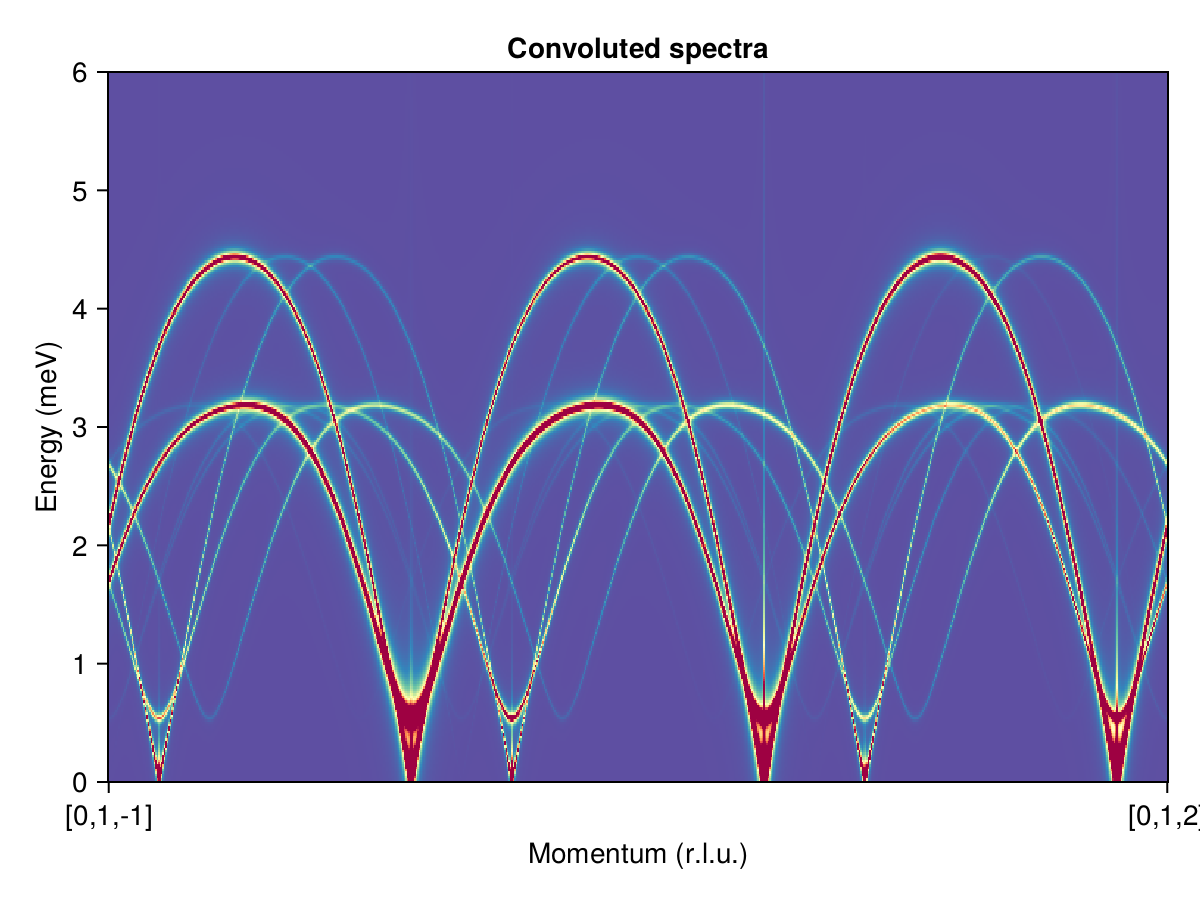

In [ ]:
CairoMakie.activate!()
γ = 0.02 
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.02:12)  
is = intensities_broadened(swt, path, energies, broadened_formula);

fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)", title="Convoluted spectra", xticks)
ylims!(ax, 0.0, 6.0)
pl=heatmap!(ax, 1:size(is, 1), energies, is,color="black",colorrange=(0,8))
pl.colormap = Reverse(:Spectral)
fig

Now, Single Q method will be used to reproduce the results. The crystal has been set up already. Set up the system again with a smaller supercell (1,1,1).

In [3]:
sys=System(Fe, (1,1,1),[SpinInfo(1,S=5/2,g=2)], :dipole, seed=0)

System [Dipole mode]
Lattice (1×1×1)×3
Energy per site 0


Set up the exchanges and the Hamiltonian just as in the Supercell method.

In [4]:
eD = -1;
eH = +1;
eT = eD*eH;

J1 = 0.85;
J2 = 0.24;
J3 = 0.053;
J4 = 0.017;
J5 = 0.24;
D=0.01
set_exchange!(sys,J1,Bond(3, 2, [1, 1, 0]))
set_exchange!(sys,J2,Bond(1, 3, [0, 0, 0]))
set_exchange!(sys,J4,Bond(1, 1, [0, 0, 1]))
if eT==1
    set_exchange!(sys,J3,Bond(3, 2, [1, 1, 1]))
    set_exchange!(sys,J5,Bond(2, 3, [-1, -1, 1]))
elseif eT==-1
    set_exchange!(sys,J3,Bond(2, 3, [-1, -1, 1]))
    set_exchange!(sys,J5,Bond(3, 2, [1, 1, 1]))
end

Specify an axis of rotation. Randomize the spins, and use minimize_energy_spiral! tp obtain the propagation vector.

In [5]:
n = [0.0,0.0,1]
randomize_spins!(sys)
n = [0.0,0.0,1]
k=Sunny.minimize_energy_spiral!(sys, n)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -2.272209351661662e-10
 -2.1640288609536304e-10
  0.14264604656221272

Set up the LSWT object and a path to obtain the dispersion and intensity bands. Note that different functions have been used to calculate the bands for single Q method as compared to supercell method.

In [7]:
q_points=[[0,1,-1],[0,1,2]]
density = 200
path, xticks = reciprocal_space_path(Fe, q_points, density);
swt = SpinWaveTheory(sys)
formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=delta_function_kernel)
disp, intensity = Sunny.intensities_bands_SingleQ(swt, path, formula);

Plot the spin wave spectrum

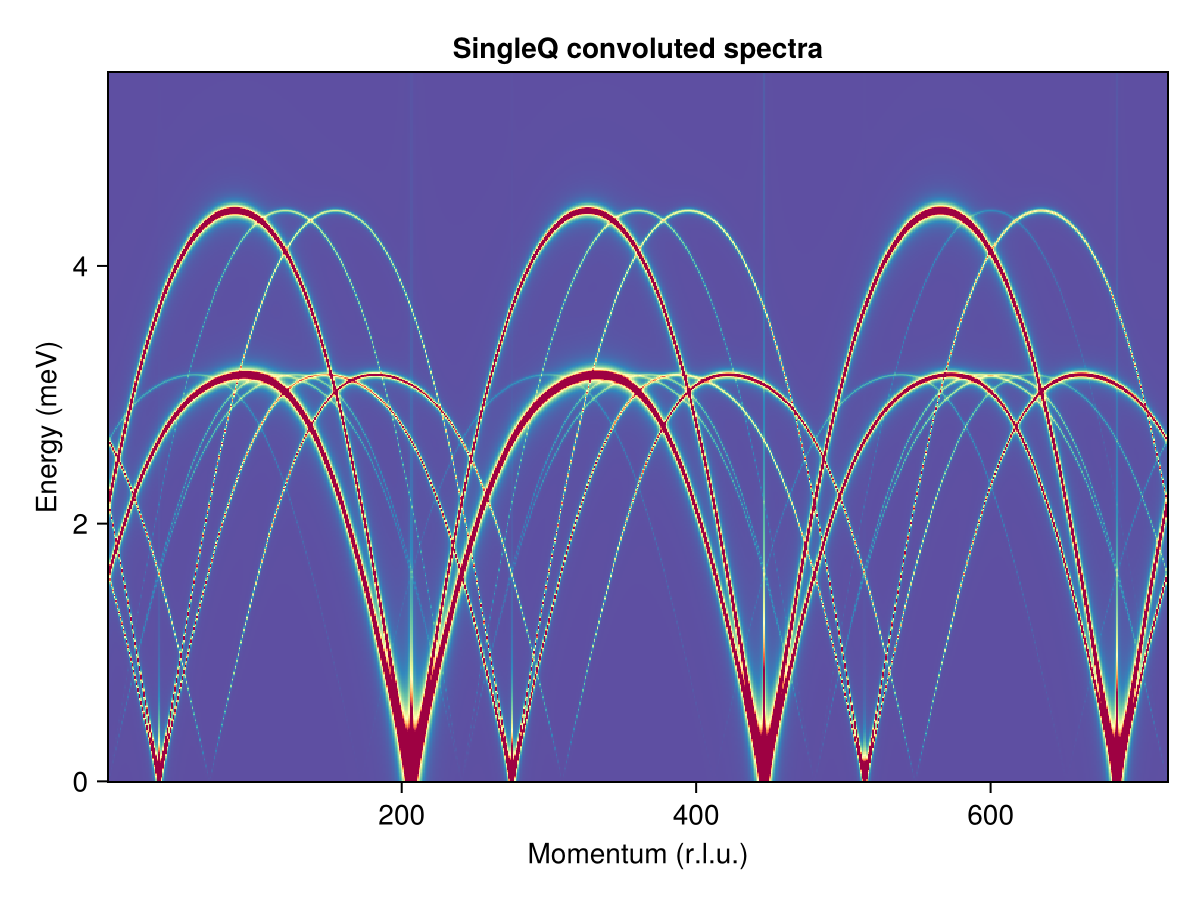

In [10]:
γ = 0.01
energies = collect(0:0.01:5.5)
broadened_formula = Sunny.intensity_formula_SingleQ(swt,k,n, :perp; kernel=lorentzian(γ),formfactors=nothing)
is = Sunny.intensities_broadened_SingleQ(swt, path, energies, broadened_formula);

begin
    CairoMakie.activate!()
    fig = Figure() 
    ax = Axis(fig[1,1];title="SingleQ convoluted spectra", xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)")
    pl = heatmap!(ax,1:size(is, 1),energies,dropdims(sum(is[:,:,:,1:3],dims=[3,4]),dims=(3,4)))
    pl.colormap = Reverse(:Spectral)
    pl.colorrange = (0,4)
    fig
end

